# Visualizing 
Here we explore methods to understand what an neural network is looking for / what the network was looking at when a prediction is made.

Methods include:
- Saliency Maps
- Class Activation Maps (Class-discriminative saliency maps)

## Saliency Maps
In computer vision, a saliency map is an image that highlights the region on which people's eyes focus first. The goal of a saliency map is to reflect the degree of importance of a pixel to the human visual system. Essentially, they are heatmaps that highlight pixels of the input image that caused the output classification.

Consider the gradient of the output class score with respect to the input image pixel values. The pixels for which this gradient would be large (either positive or negative) are the pixels that need to be changed the least to affect the class score the most. One could expect that such pixels correspond to the object's location of the image 

In [ ]:
import torch
from torchvision import models
from torchsummary import summary
import os
import cv2

import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [29]:
# 使用PyTorch与训练的VGG-19
model_path = os.path.expanduser("~/Developer/Models/vgg19")
# Check if model exists
if not os.path.exists(model_path):
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
else:
    model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1)
    model.load_state_dict(torch.load(model_path))

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [34]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

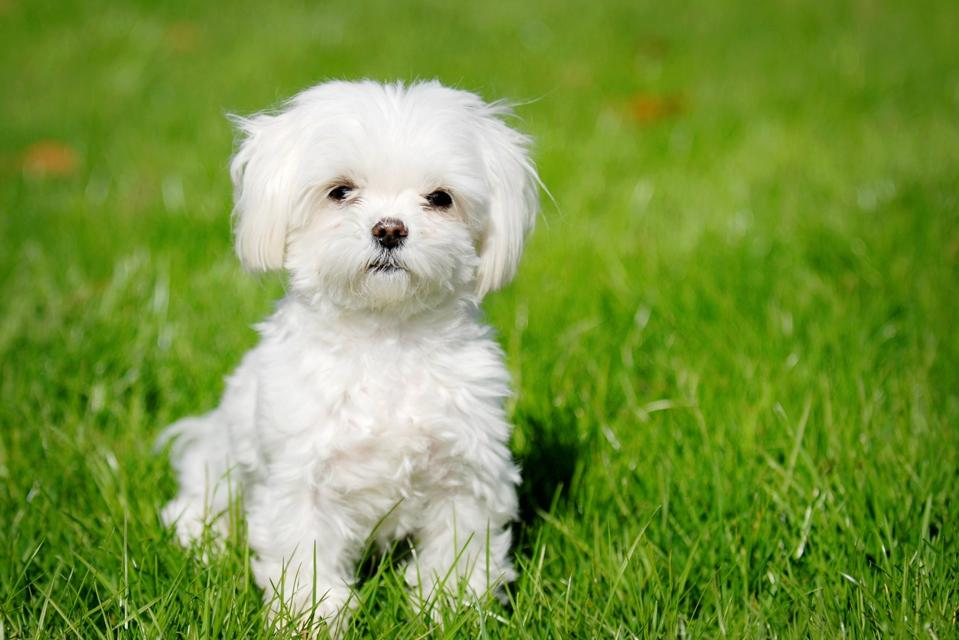

In [30]:
# 下载图像
import requests
from PIL import Image
def download(url,fname):
    response = requests.get(url)
    with open(fname,"wb") as f:
        f.write(response.content)
    
# Downloading the image    
download("https://specials-images.forbesimg.com/imageserve/5db4c7b464b49a0007e9dfac/960x0.jpg?fit=scale","input.jpg")

# Opening the image
img = Image.open('input.jpg') 
img

In [31]:
# 预处理图像
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

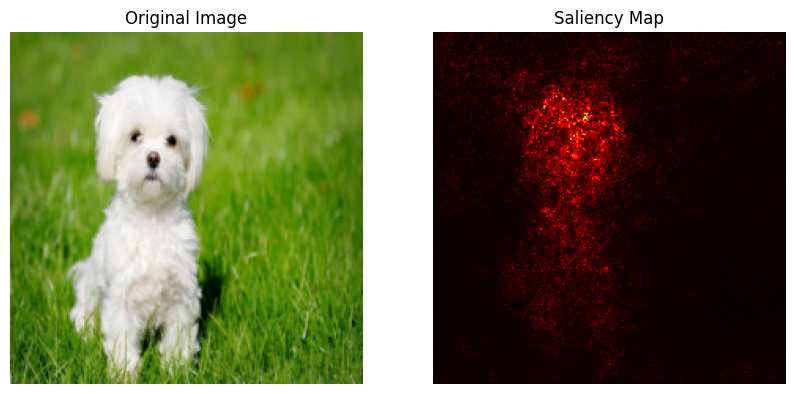

In [32]:
X = preprocess(img)
model.eval()

# we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
X.requires_grad_()
scores = model(X)

# Get the index corresponding to the maximum score and the maximum score itself.

score_max_index = scores.argmax()
score_max = scores[0, score_max_index]
score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(X.grad.data.abs(), dim=1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the original preprocessed image
axs[0].imshow(deprocess(X))
axs[0].axis('off')
axs[0].set_title('Original Image')

# Plot the saliency map as a heatmap in the second subplot
axs[1].imshow(saliency[0], cmap=plt.cm.hot)
axs[1].axis('off')
axs[1].set_title('Saliency Map')

# Display the figure
plt.show()

## Class Activation Maps, CAMs
While saliency maps give information on the most important parts of an image for a particular class, class-discriminative saliency maps help distinguish between classes. In other words, it categorizes parts/pixels of that image have contributed more to the final output of the model.

In [47]:
# Perform Class Activation Maps (CAM)
# Convert the image to a tensor and preprocess it
input_tensor = preprocess(img)
print("Shape", input_tensor.shape)

# Set the model to evaluation mode
model.eval()

# Forward pass through the model
output = model(input_tensor)

# Get the index of the predicted class
predicted_class_index = output.argmax().item()
print("Predicted Class Index", predicted_class_index)

# Get the weights of the last fully connected layer
# weights = model.fc.weight[predicted_class_index]
weights = model.classifier[6].weight[predicted_class_index]
print("Weights", weights.shape)

# Resize the weights to match the size of the feature map
weights = weights.view(1, -1, 1, 1)

# Get the feature map from the last convolutional layer
feature_map = model.features(input_tensor)
print("Feature Map", feature_map.shape)

# Perform global average pooling on the feature map
pooled_features = torch.mean(feature_map, dim=(1, 2, 3))
print("Pooled Features", pooled_features.shape)

# Perform Global Average Pooling on the feature maps
gap_features = torch.nn.functional.adaptive_avg_pool2d(feature_map, (1, 1)).squeeze()
print("Gap Features", gap_features.shape)

# Multiply the pooled features with the weights
cam = torch.matmul(gap_features, weights)

# Normalize the CAM
cam = torch.relu(cam)
print("Cam", cam.shape)

# Resize the CAM to match the size of the input image
cam = torch.nn.functional.interpolate(cam, size=(input_tensor.shape[2], input_tensor.shape[3]), mode='bilinear', align_corners=False)

# Convert the CAM to a numpy array
cam = cam.squeeze().detach().numpy()

# Normalize the CAM between 0 and 1
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

# Apply the CAM as an overlay on the input image
cam_overlay = np.uint8(255 * cam)
cam_overlay = cv2.applyColorMap(cam_overlay, cv2.COLORMAP_JET)
cam_overlay = cv2.cvtColor(cam_overlay, cv2.COLOR_BGR2RGB)

# Display the input image with the CAM overlay
plt.imshow(img)
plt.imshow(cam_overlay, alpha=0.5)
plt.axis('off')
plt.show()


Shape torch.Size([1, 3, 224, 224])
Predicted Class Index 153
Weights torch.Size([4096])
Feature Map torch.Size([1, 512, 7, 7])
Pooled Features torch.Size([1])
Gap Features torch.Size([512])


RuntimeError: size mismatch, got input (4096), mat (4096x1), vec (512)

In [48]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

targets = [ClassifierOutputTarget(153)] 

# fix the target layer (after which we'd like to generate the CAM)
target_layers = [model.layer4]

# instantiate the model
cam = GradCAM(model=model, target_layers=target_layers) # use GradCamPlusPlus class

# Preprocess input image, get the input image tensor
img = np.array(img)
img = cv2.resize(img, (300,300))
img = np.float32(img) / 255
input_tensor = preprocess_image(img)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])

# display the original image & the associated CAM
images = np.hstack((np.uint8(255*img), cam_image))
Image.fromarray(images)


SyntaxError: invalid syntax (3904641890.py, line 5)